In [1]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import dispgrad_func as dgf
import forward_model as fwd
import visualize_helper as vis

In [2]:
#%%-------------------------------------------------------
# INITIALIZATION
#---------------------------------------------------------

# Configuration files
# casename = 'diamond_10um_60deg_pbc'
# casename = 'diamond_10um_config1_pbc'
# casename = 'diamond_10um_config2_pbc'
# casename = 'diamond_10um_config3_pbc'
# casename = 'diamond_10um_screw_helix1_pbc'
# casename = 'diamond_10um_screw_helix2_pbc'
# casename = 'diamond_10um_screw_helix3_pbc'
# casename = 'diamond_10um_screw_pbc'
# casename = 'diamond_DD0039'
# casename = 'diamond_MD0_200x100x100'
casename = 'diamond_MD20000_189x100x100'
# casename = 'diamond_MD50000_174x101x100'
# casename = 'diamond_MD100000_149x100x101'
# casename = 'diamond_MD150000_131x100x104'
# casename = 'diamond_MD200000_114x100x107'

config_dir = 'configs'
config_file = os.path.join(config_dir, 'config_%s.vtk'%casename)
config_ca_file = os.path.join(config_dir, 'config_%s.ca'%casename)
config_reduced_ca_file = os.path.join(config_dir, 'config_%s_reduced.ca'%casename)

# Elasticity parameters (Diamond)
input_dict = dgf.default_dispgrad_dict('disl_network')
print(input_dict)

input_dict['nu'] = NU = 0.200       # Poisson's ratio
input_dict['b'] = bmag = 2.522e-10  # Burger's magnitude (m)
two_theta = 48.16                   # 2theta for diamond-(004) (deg)

# Load the dislocation network
disl = dgf.disl_network(input_dict)
disl.load_network(config_file)

{'b': 1, 'nu': 0.334, 'dispgrad_type': 'disl_network', 'a': 1.0}


Number of dislocations: 405


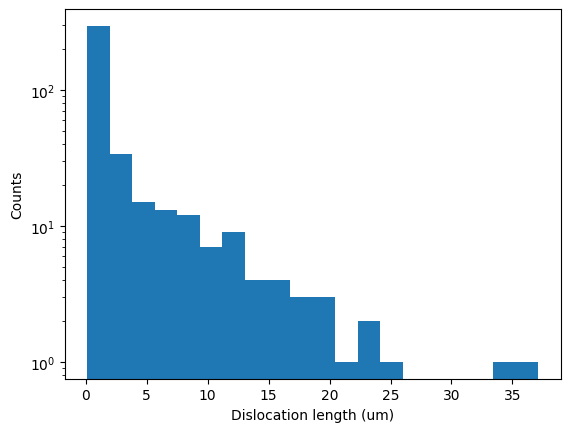

In [3]:
# Write the dislocation network into a CA file
ca_data = disl.write_network_ca(config_ca_file, bmag=bmag)
ca_data = disl.write_network_ca('config_reduced.ca', bmag=bmag, reduced=True, pbc=True)
disl_list = ca_data['disl_list']
disl_edge_list = ca_data['disl_edge_list']
print('Number of dislocations:', len(disl_list))

disl_lens = np.zeros(len(disl_list))
for i, dislocation in enumerate(disl_list):
    rvec = ca_data['rn'][dislocation[1:], :] - ca_data['rn'][dislocation[:-1], :]
    # print(rvec.shape, len(dislocation))
    # if i == 3:
    #     print(dislocation)
    #     print(disl.rn[dislocation[1], :])
    #     print(disl.rn[dislocation[0], :])
    svec = np.linalg.inv(disl.cell).dot(rvec.T).T
    svec = svec - np.round(svec)
    rvec = disl.cell.dot(svec.T).T
    disl_lens[i] = np.linalg.norm(rvec, axis=1).sum()
# print(disl_lens)

fig, ax = plt.subplots()
unit_conversion = 1e-10*1e6 # A to um
hist, bin_edges = np.histogram(disl_lens*unit_conversion, bins=20)
ax.hist(disl_lens*unit_conversion, bins=20)
ax.set_yscale('log')
ax.set_xlabel('Dislocation length (um)')
ax.set_ylabel('Counts')
plt.show()

In [5]:
phi = 0
chi = 0

print(bin_edges)

for i_edge in range(bin_edges.size - 1):
    Fg = None
    bin_Fg_file = 'data/Fg_%s_len%.4f-%.4f_phi%.4f_chi%.4f.npz'%(casename, 
        bin_edges[i_edge], bin_edges[i_edge+1], phi, chi)
    if not os.path.exists(bin_Fg_file):
        bin_disl_edge = []
        for i, dislocation in enumerate(disl_list):
            if (disl_lens[i]*unit_conversion > bin_edges[i_edge + 1] or 
                disl_lens[i]*unit_conversion < bin_edges[i_edge]):
                continue
            print(disl_edge_list[i], disl_lens[i]*unit_conversion)
            bin_disl_edge = bin_disl_edge + disl_edge_list[i]
            for iseg in disl_edge_list[i]:
                Fg_path = 'data/Fg_%s_seg'%casename
                saved_Fg_file = os.path.join(Fg_path, 'Fg_iseg%d_phi%.4f_chi%.4f.npz'%(iseg, phi, chi))
                if Fg is None:
                    Fg = np.load(saved_Fg_file)['Fg']
                    r_obs = np.load(saved_Fg_file)['r_obs']
                else:
                    Fg += np.load(saved_Fg_file)['Fg']

        np.savez_compressed(bin_Fg_file, Fg=Fg, r_obs=r_obs, select_seg=bin_disl_edge)
    else:
        bin_disl_edge = np.load(bin_Fg_file)['select_seg']

[ 0.10405174  1.95404434  3.80403694  5.65402955  7.50402215  9.35401476
 11.20400736 13.05399996 14.90399257 16.75398517 18.60397777 20.45397038
 22.30396298 24.15395559 26.00394819 27.85394079 29.7039334  31.553926
 33.40391861 35.25391121 37.10390381]
[8, 9, 10, 11, 12, 13, 14] 3.0169656009230286
[48, 49, 50, 51, 52, 53, 54] 2.967216685764463
[82, 83, 84, 85, 86, 87, 88] 2.9028950745750612
[348, 349, 350, 351, 352] 2.0732182309917966
[361, 362, 363, 364, 365, 366] 2.1465996172288575
[374, 375, 376, 377, 378, 379] 2.4907947042422616
[466, 467, 468, 469, 470, 471, 472] 2.820435834856098
[476, 477, 478, 479, 480, 481] 2.2879720831735426
[521, 522, 523, 524, 525, 526] 2.2841642799263004
[602, 603, 604, 605, 606, 607, 608] 3.0436026884904233
[803, 804, 805, 806, 807, 808, 809] 3.0472468850052903
[816, 817, 818, 819, 820] 2.1752347861174166
[879, 880] 3.118699843172044
[882, 883, 884, 885, 886, 887, 888, 889] 3.432747805259486
[961, 962, 963, 964, 965] 1.9576746858500265
[968, 969] 3.3992

In [6]:
Fg = None
select_seg = None
for i_edge in range(bin_edges.size - 1):
    bin_Fg_file = 'data/Fg_%s_len%.4f-%.4f_phi%.4f_chi%.4f.npz'%(casename, 
        bin_edges[i_edge], bin_edges[i_edge+1], phi, chi)
    print(bin_Fg_file)
    if Fg is None:
        Fg = np.load(bin_Fg_file)['Fg']
        r_obs = np.load(bin_Fg_file)['r_obs']
        select_seg = np.load(bin_Fg_file)['select_seg']
    else:
        try:
            Fg_single = np.load(bin_Fg_file)['Fg']
        except:
            Fg_single = 0
        Fg += Fg_single
        select_seg = np.concatenate([select_seg, np.load(bin_Fg_file)['select_seg']])
bins_Fg_file = 'data/Fg_%s_phi%.4f_chi%.4f.npz'%(casename, phi, chi)
np.savez_compressed(bins_Fg_file, Fg=Fg, r_obs=r_obs, select_seg=select_seg)

data/Fg_diamond_MD20000_189x100x100_len0.1041-1.9540_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len1.9540-3.8040_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len3.8040-5.6540_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len5.6540-7.5040_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len7.5040-9.3540_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len9.3540-11.2040_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len11.2040-13.0540_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len13.0540-14.9040_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len14.9040-16.7540_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len16.7540-18.6040_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len18.6040-20.4540_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len20.4540-22.3040_phi0.0000_chi0.0000.npz
data/Fg_diamond_MD20000_189x100x100_len22.3040-24.1540_phi0.000

In [7]:
#%%-------------------------------------------------------
# CALCULATE THE DISPLACEMENT GRADIENT
#---------------------------------------------------------

forward_dict = fwd.default_forward_dict()
forward_dict['two_theta'] = two_theta
print(forward_dict)

# Set up the pre-calculated resolution function
datapath = 'data'
os.makedirs(datapath, exist_ok=True)
saved_res_fn = os.path.join(datapath, 'Res_qi_diamond_001.npz')
print('saved resolution function at %s'%saved_res_fn)

# Set up the pre-calculated displacement gradient
saved_Fg_file = os.path.join(datapath, 'Fg_%s_visualize.npz'%casename)

model = fwd.DFXM_forward(forward_dict, load_res_fn=saved_res_fn)
Ug = model.Ug
print('Ug')
print(Ug)

{'x_c': [1, 0, 0], 'y_c': [0, 1, 0], 'hkl': [0, 0, 1], 'two_theta': 48.16, 'b': 2.86e-10, 'psize': 7.5e-08, 'Npixels': [50, 45, 40], 'Nrays': 10000000, 'q1_range': 0.008, 'npoints1': 40, 'q2_range': 0.008, 'npoints2': 40, 'q3_range': 0.008, 'npoints3': 40, 'zeta_v_rms': 0.000225531914893617, 'zeta_h_rms': 4.255319148936171e-06, 'NA_rms': 0.00031106382978723403, 'eps_rms': 6e-05, 'zl_rms': 2.553191489361702e-07, 'D': 0.00044721359549995795, 'd1': 0.274, 'TwoDeltaTheta': 0, 'phi': 0, 'chi': 0, 'omega': 0, 'mu': 0.36180675393842454, 'theta': 0.18090337696921227}
saved resolution function at data/Res_qi_diamond_001.npz
Ug
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


(100, 90, 80, 3)


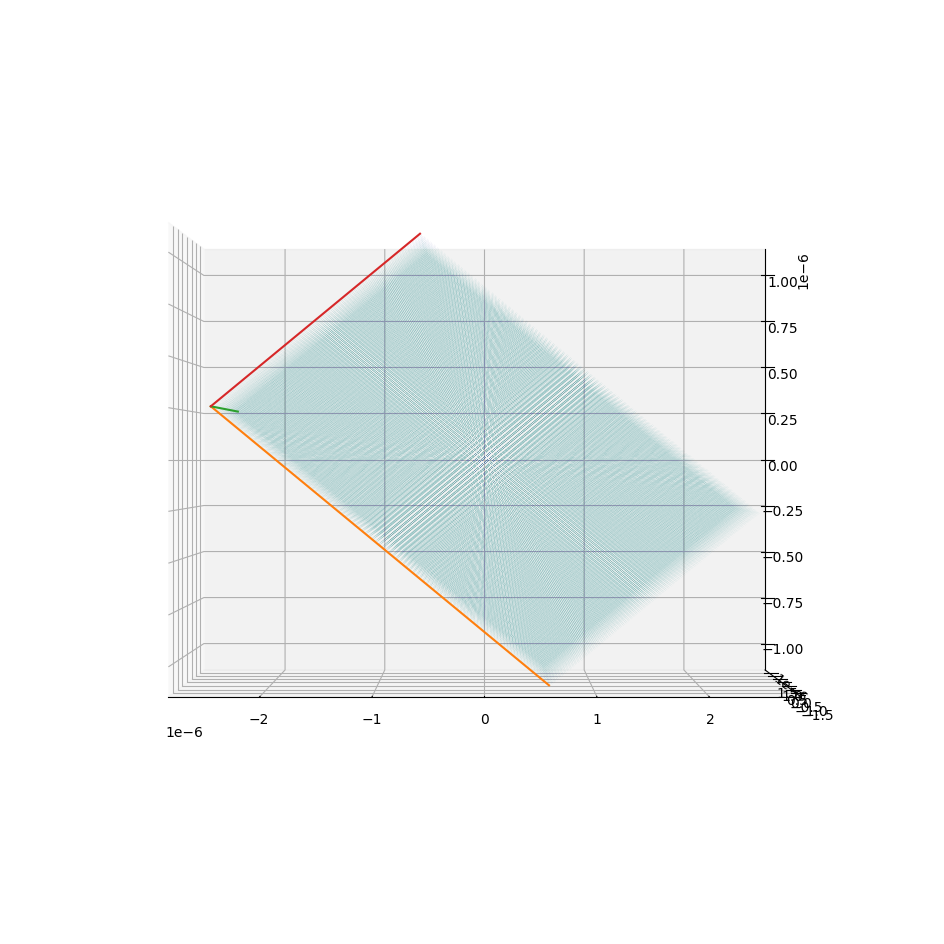

In [8]:
i_edge = 0
bin_Fg_file = os.path.join('data', 
                           'Fg_%s_len%.4f-%.4f_phi%.4f_chi%.4f.npz'%(casename, 
                            bin_edges[i_edge], bin_edges[i_edge+1], phi, chi))
select_seg = np.load(bin_Fg_file)['select_seg']
r_obs = np.load(bin_Fg_file)['r_obs']
NNxyz = (100, 90, 80)
NNxyz = (100, 80, 90)

# r_obs_cell = np.swapaxes(np.reshape(r_obs, NNxyz + (3, ), order='F'), 1, 2)
r_obs_cell = np.reshape(r_obs, NNxyz + (3, ), order='F')
r_obs_cell = np.swapaxes(r_obs_cell, 1, 2)
print(r_obs_cell.shape)
# print(r_obs[:100])
# print(r_obs_cell[-1,0,0,:], r_obs_cell[0,0,0,:])
# print(r_obs_cell[0,-1,0,:], r_obs_cell[0,0,-1,:])
# print(r_obs_cell[-1,-1,0,:], r_obs_cell[-1,0,-1,:])
# print(r_obs_cell[0, -1, -1,:], r_obs_cell[-1, -1, -1, :])
# print(r_obs_cell[::10, 0, 0, :])
# print(r_obs_cell[0, ::10, 0, :])
Hb = r_obs_cell[-1, 0, 0,:] - r_obs_cell[0,0,0,:]
Ha = r_obs_cell[0, -1, 0,:] - r_obs_cell[0,0,0,:]
Hc = r_obs_cell[0, 0, -1,:] - r_obs_cell[0,0,0,:]
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
nskip = 1
ax.plot(r_obs[::nskip, 0], r_obs[::nskip, 1], r_obs[::nskip, 2], '.', markersize=0.01)
# ax.plot(r_obs[:100, 0], r_obs[:100, 1], r_obs[:100, 2], '-')
# ax.plot(r_obs[:8000:100, 0], r_obs[:8000:100, 1], r_obs[:8000:100, 2], '-')
# ax.plot(r_obs[::8000, 0], r_obs[::8000, 1], r_obs[::8000, 2], '-')
ax.plot(r_obs_cell[:, 0, 0, 0], r_obs_cell[:, 0, 0, 1], r_obs_cell[:, 0, 0, 2], '-')
ax.plot(r_obs_cell[0, :, 0, 0], r_obs_cell[0, :, 0, 1], r_obs_cell[0, :, 0, 2], '-')
# ax.plot(r_obs_cell[0, :, 2, 0], r_obs_cell[0, :, 2, 1], r_obs_cell[0, :, 2, 2], '-')
ax.plot(r_obs_cell[0, 0, :, 0], r_obs_cell[0, 0, :, 1], r_obs_cell[0, 0, :, 2], '-')
# ax.view_init(elev=90, azim=0)
ax.view_init(elev=0, azim=-90)
plt.show()

data/Fg_diamond_MD20000_189x100x100_len0.1041-1.9540_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len0.1041-1.9540_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.74s
Image calculation: 1.79s
103.97335749645444 131.70208969631827


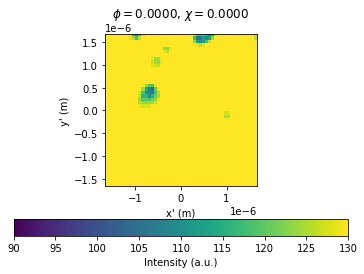

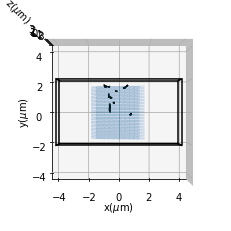

data/Fg_diamond_MD20000_189x100x100_len1.9540-3.8040_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len1.9540-3.8040_phi0.0000_chi0.0000.npz
Initialization time: 0.01s
Calculate the wave vectors: 1.74s
Image calculation: 1.79s
94.86572396256558 131.70208969631827


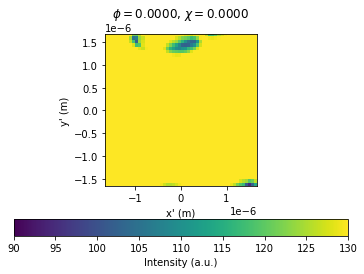

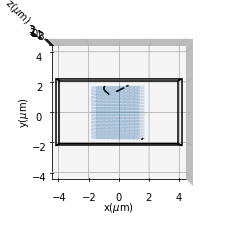

data/Fg_diamond_MD20000_189x100x100_len3.8040-5.6540_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len3.8040-5.6540_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.66s
Image calculation: 1.70s
84.4527012428735 131.70208969631827


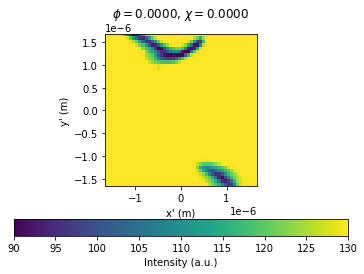

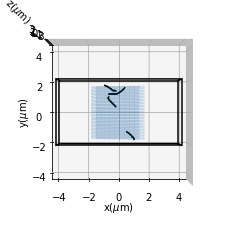

data/Fg_diamond_MD20000_189x100x100_len5.6540-7.5040_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len5.6540-7.5040_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.74s
Image calculation: 1.79s
112.73974847904601 131.70208969631827


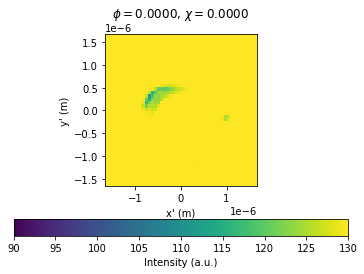

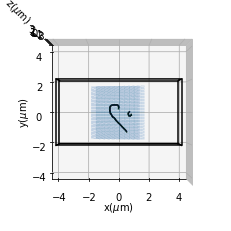

data/Fg_diamond_MD20000_189x100x100_len7.5040-9.3540_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len7.5040-9.3540_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.71s
Image calculation: 1.76s
114.49339878593115 131.70208969631827


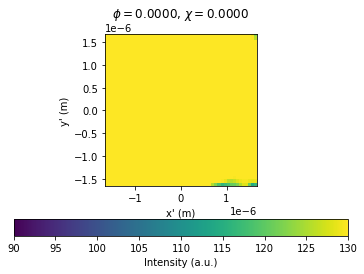

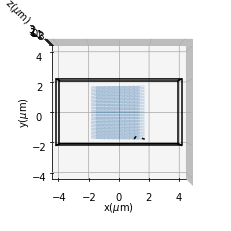

data/Fg_diamond_MD20000_189x100x100_len9.3540-11.2040_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len9.3540-11.2040_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.70s
Image calculation: 1.74s
91.40640170060814 131.70208969631827


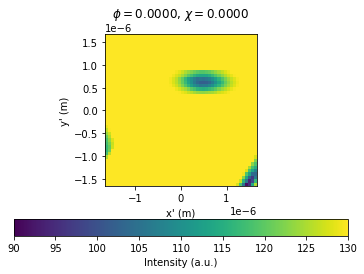

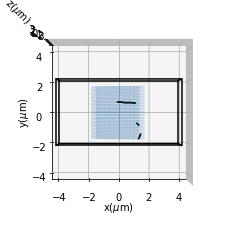

data/Fg_diamond_MD20000_189x100x100_len11.2040-13.0540_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len11.2040-13.0540_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.62s
Image calculation: 1.66s
103.96865793199831 131.70208969631827


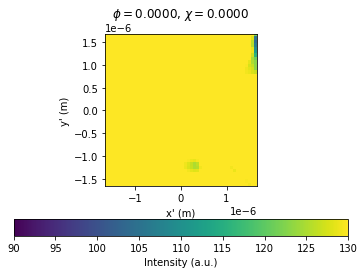

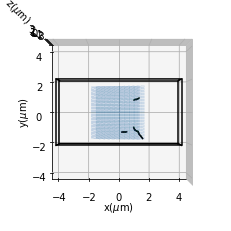

data/Fg_diamond_MD20000_189x100x100_len13.0540-14.9040_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len13.0540-14.9040_phi0.0000_chi0.0000.npz
Initialization time: 0.01s
Calculate the wave vectors: 1.65s
Image calculation: 1.69s
120.39739843512884 131.70208969631827


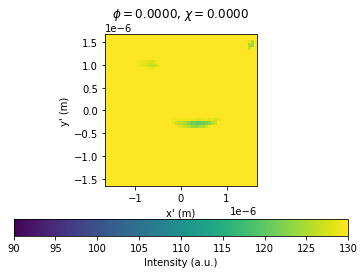

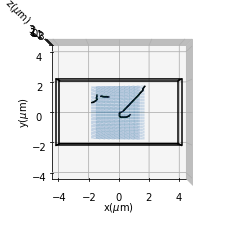

data/Fg_diamond_MD20000_189x100x100_len14.9040-16.7540_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len14.9040-16.7540_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.62s
Image calculation: 1.66s
72.20543949247973 131.70208969631827


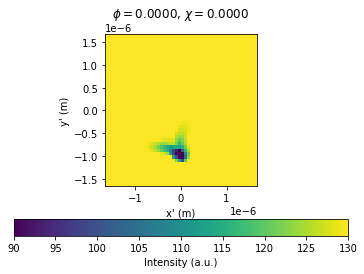

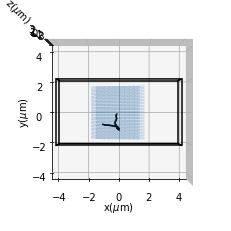

data/Fg_diamond_MD20000_189x100x100_len16.7540-18.6040_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len16.7540-18.6040_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.65s
Image calculation: 1.69s
129.49024641979514 131.70208969631827


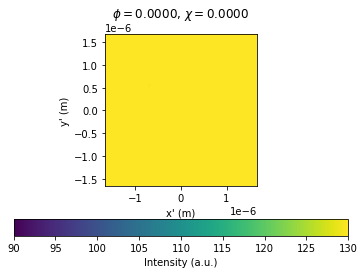

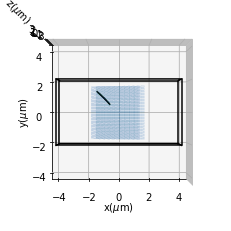

data/Fg_diamond_MD20000_189x100x100_len18.6040-20.4540_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len18.6040-20.4540_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.71s
Image calculation: 1.75s
127.42912682959013 131.70208969631827


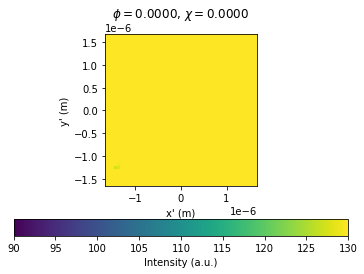

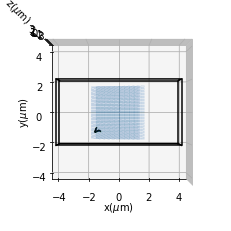

data/Fg_diamond_MD20000_189x100x100_len20.4540-22.3040_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len20.4540-22.3040_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.70s
Image calculation: 1.75s
131.70208969631827 131.70208969631827


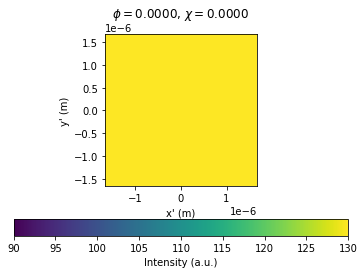

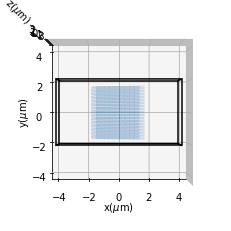

data/Fg_diamond_MD20000_189x100x100_len22.3040-24.1540_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len22.3040-24.1540_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.70s
Image calculation: 1.75s
119.966071967537 131.70208969631827


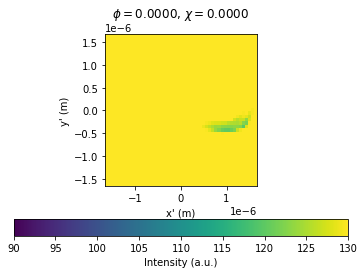

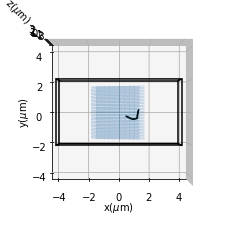

data/Fg_diamond_MD20000_189x100x100_len24.1540-26.0039_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len24.1540-26.0039_phi0.0000_chi0.0000.npz
Initialization time: 0.00s
Calculate the wave vectors: 1.65s
Image calculation: 1.68s
128.93969117778903 131.70208969631827


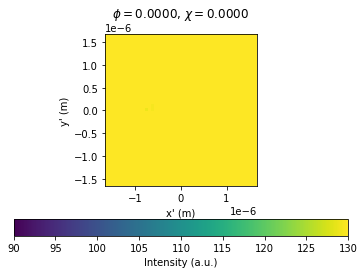

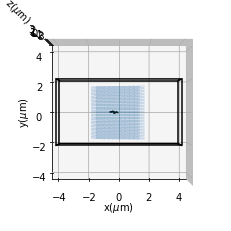

data/Fg_diamond_MD20000_189x100x100_len26.0039-27.8539_phi0.0000_chi0.0000.npz
[[3.03475702e-06 0.00000000e+00 6.27213711e-07]
 [0.00000000e+00 3.33750000e-06 0.00000000e+00]
 [1.35624132e-06 0.00000000e+00 1.95823790e-06]]
#################### Calculate and visualize the image
saved displacement gradient at data/Fg_diamond_MD20000_189x100x100_len26.0039-27.8539_phi0.0000_chi0.0000.npz
Initialization time: 0.00s


ValueError: Object arrays cannot be loaded when allow_pickle=False

In [ ]:
dataPath = os.path.join('data')
os.makedirs(dataPath, exist_ok=True)
for i_edge in range(bin_edges.size - 2):
    bin_Fg_file = os.path.join(dataPath, 'Fg_%s_len%.4f-%.4f_phi%.4f_chi%.4f.npz'%(casename, 
        bin_edges[i_edge], bin_edges[i_edge+1], phi, chi))
    output_file = os.path.join(dataPath, 'output_%s_len%.4f-%.4f_phi%.4f_chi%.4f'%(casename, 
        bin_edges[i_edge], bin_edges[i_edge+1], phi, chi))
    print(bin_Fg_file)
    try:
        select_seg = np.load(bin_Fg_file)['select_seg']
        r_obs = np.load(bin_Fg_file)['r_obs']
        NNxyz = (100, 80, 90)
    except:
        continue
        
    # Filter out the segments outside of the beam
    r_obs_cell = np.swapaxes(np.reshape(r_obs, NNxyz + (3, ), order='F'), 1, 2)
    obs_cell = np.transpose([r_obs_cell[-1, 0, 0, :] - r_obs_cell[0, 0, 0, :], 
                             r_obs_cell[0, -1, 0, :] - r_obs_cell[0, 0, 0, :],
                             r_obs_cell[0, 0, -1, :] - r_obs_cell[0, 0, 0, :]
                            ])
    print(obs_cell)
    disl.load_network(config_file, scale_cell=1/4)
    select_seg_inside = []
    select_seg_outside = []
    for ilink in select_seg:
        link = disl.links[ilink]
        end1 = disl.rn[int(link[0])]*bmag
        end2 = disl.rn[int(link[1])]*bmag
        s1 = np.linalg.inv(obs_cell).dot(end1)
        s2 = np.linalg.inv(obs_cell).dot(end2)
        if np.all(np.abs(s1) < 0.5) or np.all(np.abs(s2) < 0.5):
            select_seg_inside.append(ilink)

    print('#'*20 + ' Calculate and visualize the image')
    # saved_Fg_file = os.path.join(datapath, 'Fg_%s_DFXM.npz'%casename)
    # bin_Fg_file = bins_Fg_file
    print('saved displacement gradient at %s'%bin_Fg_file)
    Fg_func = lambda x, y, z: disl.Fg(x, y, z, filename=bin_Fg_file)
    im, ql, rulers = model.forward(Fg_func, timeit=True)
    print(im.min(), im.max())
    # Visualize the simulated image
    figax = vis.visualize_im_qi(forward_dict, im, None, rulers, vlim_im=[90, 130])
    figax[0].savefig(output_file+'_DFXM.png', dpi=300)

    disl.load_network(config_file, select_seg=select_seg_inside, scale_cell=1/4)
    config_ca_file = os.path.join(dataPath, 'config_%s_len%.4f-%.4f_phi%.4f_chi%.4f.ca'%(casename, bin_edges[i_edge], bin_edges[i_edge+1], phi, chi))
    ca_data = disl.write_network_ca(config_ca_file, bmag=bmag)
    r_obs = np.load(bin_Fg_file)['r_obs']/bmag
    r_obs_xyz_file = os.path.join(dataPath, 'r_obs_%s_len%.4f-%.4f_phi%.4f_chi%.4f.xyz'%(casename, bin_edges[i_edge], bin_edges[i_edge+1], phi, chi))
    from disl_io_helper import write_xyz
    write_xyz(r_obs_xyz_file, r_obs)

    Lx, Ly, Lz = tuple(np.diag(disl.cell))
    lbx, ubx, lby, uby, lbz, ubz = -Lx/2, Lx/2, -Ly/2, Ly/2, -Lz/2, Lz/2 # in unit of b
    unit_conversion = 1e6 # in the unit of m
    extent = np.multiply(bmag*unit_conversion, [lbx, ubx, lby, uby, lbz, ubz])
    fig, ax = vis.visualize_disl_network(disl.d, disl.rn, disl.links, extent=extent, unit='um', show=False) #, figax=(fig, ax))
    nskip = 10
    r_obs = np.load(bin_Fg_file)['r_obs']*unit_conversion
    ax.plot(r_obs[::nskip, 0], r_obs[::nskip, 1], r_obs[::nskip, 2],  'C0.', markersize=0.01)
    fig.savefig(output_file+'_3D.png', dpi=300)
    ax.view_init(elev=90, azim=-90)
    fig.savefig(output_file+'_top.png', dpi=300)
    plt.show()